# Fitting Sigmoid functions to empirical NN distribution


4/11/2022
Shiqi Jiang

In [1]:
# 9 Species: AT, CE, DM, ...
# 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter

### normalization on AT

In [3]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
data_locations = [r"D:\file\Research\P-value\data\AT"+c for c in classes]
data_locations_CE = [r"D:\file\Research\P-value\data\CE"+c for c in classes]

In [4]:
def combine_data(data_location,classes):
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb

In [5]:
df_comb = combine_data(data_locations,classes)
df_class = df_comb['class']
df_comb = df_comb.drop("class", axis = 1)
df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
df_comb['class'] = df_class.reset_index(drop = True)

In [6]:
df_CE = combine_data(data_locations_CE,classes)
df_class_CE = df_CE['class']
df_CE = df_CE.drop("class", axis = 1)
df_CE = pd.DataFrame(MinMaxScaler().fit_transform(df_CE))
df_CE['class'] = df_class_CE.reset_index(drop = True)

In [7]:
# calling data(data_frame, class_name) return Species-Class empirical data as an array
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

### helper functions

In [25]:
# calculating empirical data's shortest(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=100)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return


# get x,y data from CDF of empirical NN
def empirical_CDF(data, Density,title):
    '''
    return x,y data of CDF
    if density==True, y is percentage where y[-1]=1 
    '''    
    fig = plt.figure()
    h = plt.hist(data,bins=len(data),density=Density,cumulative=True,histtype='stepfilled')    # bins set to equal to # of empirical data
    x = h[1][:-1]
    y = h[0]
    plt.close(fig)
    ##plt.show()
    return x,y


# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func,s, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
    else:
        p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
    
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm', sigma=y)

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt


# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class(data, name, factor, func_list, color_list):
    x,y = empirical_CDF(data, True, name)
    
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].scatter(x,1-y, color='b',s=10)
    
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    
    print("For ",name," :")
    for i in range(len(func_list)):
        try:
            if i == 7:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")
            elif i == 6:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
            else:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y)
        except RuntimeError:
            print("error in ",str(func_list[i])[9:-22])
            continue
        y2 = func_list[i](x/factor, *p)
        ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
    
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()

### Sigmoid functions

In [35]:
# 4.11 Adjust range to (0,1)

def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): # for log curve_fit
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = 0.5*(2/np.pi)*np.arctan(k*(x-x0)) + 0.5
    return m

def GD(x, x0, k):
    m = (4/np.pi)*np.arctan(np.tanh(k*(x-x0)))
    return m

def ERF(x, x0, k):
    m = erf(k*(x-x0))
    return m

def algebra(x, x0, k):
    m = x/((1+abs(x)**k)**(1/k))
    return m

### 3.7 meeting.  Weighted_combination of arctan+GD
def arctan_GD(x,x0,k, w):
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return m

def Gompertz(x,b,c):
    m = np.e**(-np.e**(b-c*x))
    return m

### Fitting

In [10]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
factors = [1e-5,  1e-2,   1e-4,   1e-3,   1e-2,  1e-4, 1e-2,   1e-3]
colors = ['g','r','c','m','y','k','brown','gray']
functions = [logistic, tanh, arctan, GD, ERF, algebra, arctan_GD, Gompertz]

For  ER  :
curve_fit parameter on  logistic :  [4.51953078 0.82438936]
curve_fit parameter on  tanh :  [4.51952863 0.41219492]
curve_fit parameter on  arctan :  [0.69102549 0.24087834]
curve_fit parameter on  GD :  [0.62923474 0.10135211]
curve_fit parameter on  ERF :  [0.61112498 0.10925362]
curve_fit parameter on  algebra :  [4.74320923 0.45346804]
curve_fit parameter on  arctan_GD :  [3.90589198 0.34428307 0.18872987]
curve_fit parameter on  Gompertz :  [1.53682703 0.41422053]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


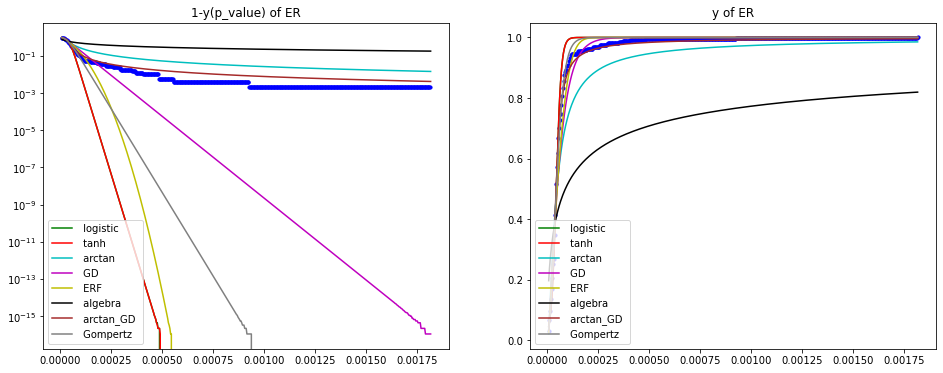

For  ERDD  :
curve_fit parameter on  logistic :  [0.91525059 7.21990862]
curve_fit parameter on  tanh :  [0.91524698 3.60997285]
curve_fit parameter on  arctan :  [0.1911103  0.54024716]
curve_fit parameter on  GD :  [0.19015267 0.25452071]
curve_fit parameter on  ERF :  [0.18980365 0.28126157]
curve_fit parameter on  algebra :  [1.01217827 0.20473379]
curve_fit parameter on  arctan_GD :  [0.91789993 3.40632404 0.10750034]
curve_fit parameter on  Gompertz :  [2.28069374 2.88124263]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


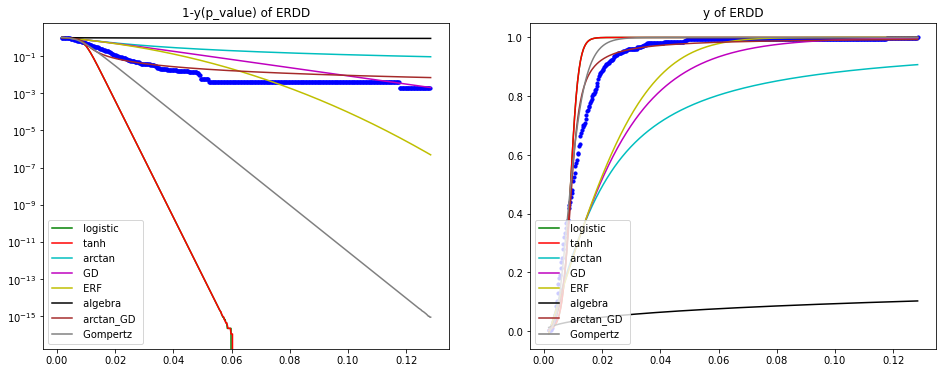

For  GEO  :
curve_fit parameter on  logistic :  [1.92774763 3.86156076]
curve_fit parameter on  tanh :  [1.92774496 1.93078549]
curve_fit parameter on  arctan :  [0.66289502 0.50306608]
curve_fit parameter on  GD :  [0.66074458 0.22680531]
curve_fit parameter on  ERF :  [0.66006196 0.24814465]
curve_fit parameter on  algebra :  [2.07712928 0.20314146]
curve_fit parameter on  arctan_GD :  [1.82091963 1.02676518 0.19895665]
curve_fit parameter on  Gompertz :  [2.67969497 1.5720655 ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


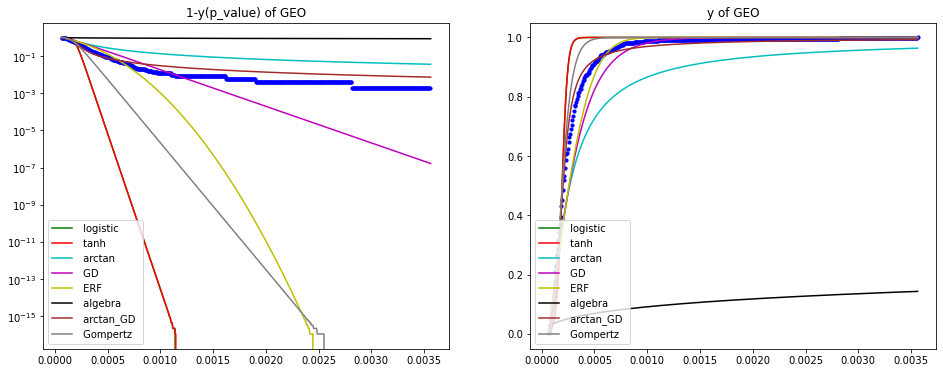

For  GEOGD  :
curve_fit parameter on  logistic :  [0.3883875  6.36909317]
curve_fit parameter on  tanh :  [0.38838893 3.18452871]
curve_fit parameter on  arctan :  [0.03697566 3.51984779]
curve_fit parameter on  GD :  [0.01252291 1.20991988]
curve_fit parameter on  ERF :  [0.00634023 1.26356544]
curve_fit parameter on  algebra :  [0.35420422 2.3204201 ]
curve_fit parameter on  arctan_GD :  [0.19794372 1.9742399  0.45139616]
curve_fit parameter on  Gompertz :  [1.07745918 3.79035775]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


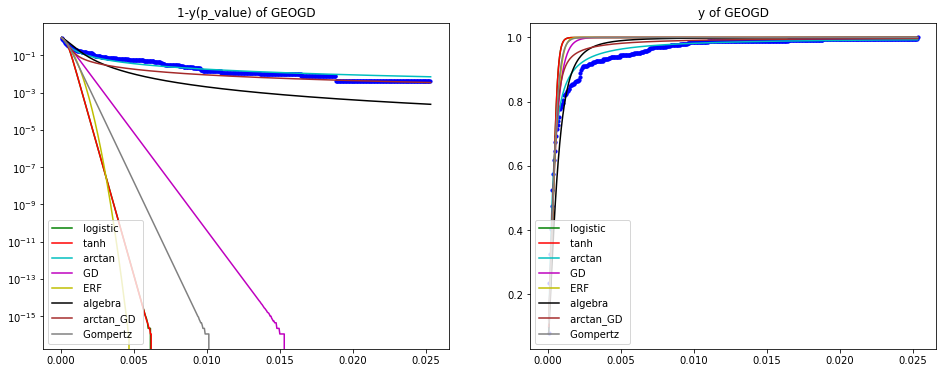

For  HGG  :
curve_fit parameter on  logistic :  [8.31967744 0.71512279]
curve_fit parameter on  tanh :  [8.31959073 0.35756673]
curve_fit parameter on  arctan :  [2.00083144 0.08326023]
curve_fit parameter on  GD :  [1.9850286  0.03877571]
curve_fit parameter on  ERF :  [1.9779164 0.042448 ]
curve_fit parameter on  algebra :  [8.94144704 0.16784947]
curve_fit parameter on  arctan_GD :  [8.13288555 0.25448335 0.15683149]
curve_fit parameter on  Gompertz :  [2.18005979 0.2964794 ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


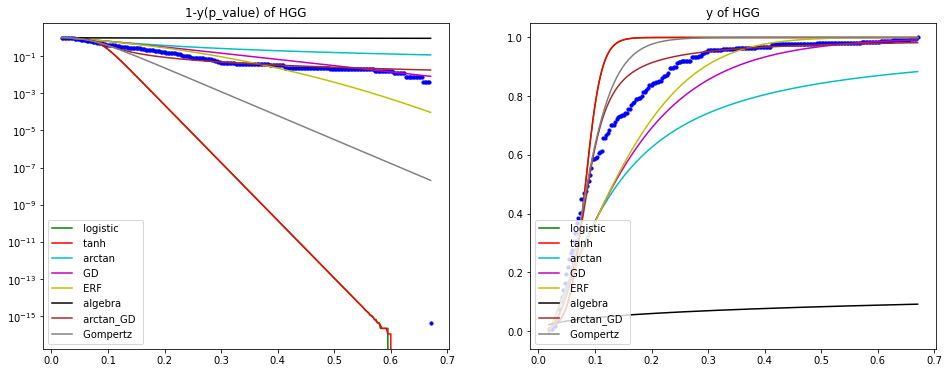

For  SF  :
curve_fit parameter on  logistic :  [2.70904861 2.80140464]
curve_fit parameter on  tanh :  [2.70904343 1.4007076 ]
curve_fit parameter on  arctan :  [1.13342952 0.32103115]
curve_fit parameter on  GD :  [1.1289473  0.15093577]
curve_fit parameter on  ERF :  [1.12726226 0.16659944]
curve_fit parameter on  algebra :  [2.82972287 0.19770122]
curve_fit parameter on  arctan_GD :  [2.65373393 1.43919589 0.11538742]
curve_fit parameter on  Gompertz :  [2.88538892 1.14177237]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


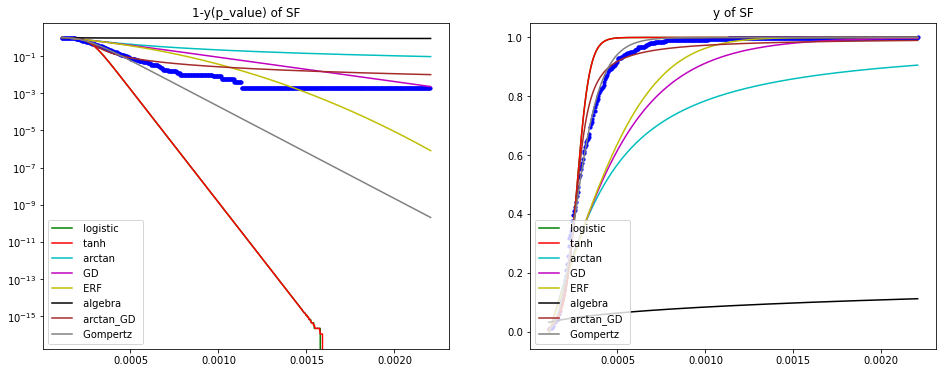

For  SFDD  :
curve_fit parameter on  logistic :  [1.36406246 4.55149761]
curve_fit parameter on  tanh :  [1.36405518 2.27576467]
curve_fit parameter on  arctan :  [0.23615806 0.3252526 ]
curve_fit parameter on  GD :  [0.23326251 0.14867519]
curve_fit parameter on  ERF :  [0.23252878 0.16417691]
curve_fit parameter on  algebra :  [1.55198565 0.26114068]
curve_fit parameter on  arctan_GD :  [1.40955659 2.28386997 0.09990192]
curve_fit parameter on  Gompertz :  [2.12961521 1.7057228 ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


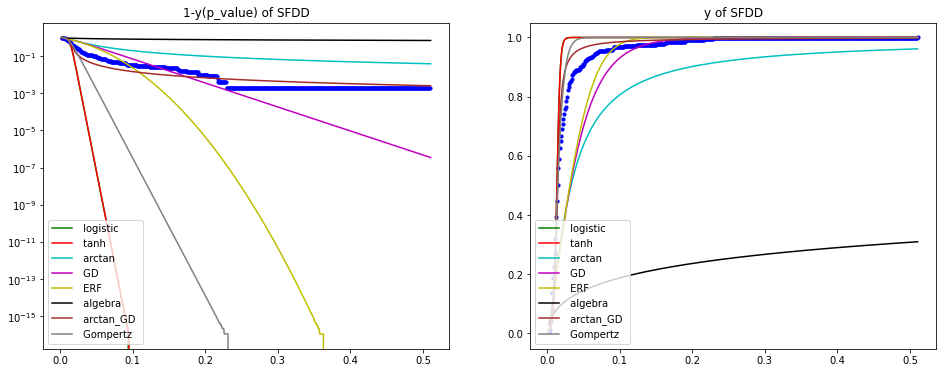

For  Sticky  :
curve_fit parameter on  logistic :  [5.36043424 1.90066386]
curve_fit parameter on  tanh :  [5.36044675 0.95032714]
curve_fit parameter on  arctan :  [2.35094238 0.05094383]
curve_fit parameter on  GD :  [2.35650895 0.02643797]
curve_fit parameter on  ERF :  [2.35882329 0.03030973]
curve_fit parameter on  algebra :  [5.49479545 0.12327566]
curve_fit parameter on  arctan_GD :  [5.36003599 2.43258886 0.03927486]
curve_fit parameter on  Gompertz :  [3.49805256 0.66992733]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


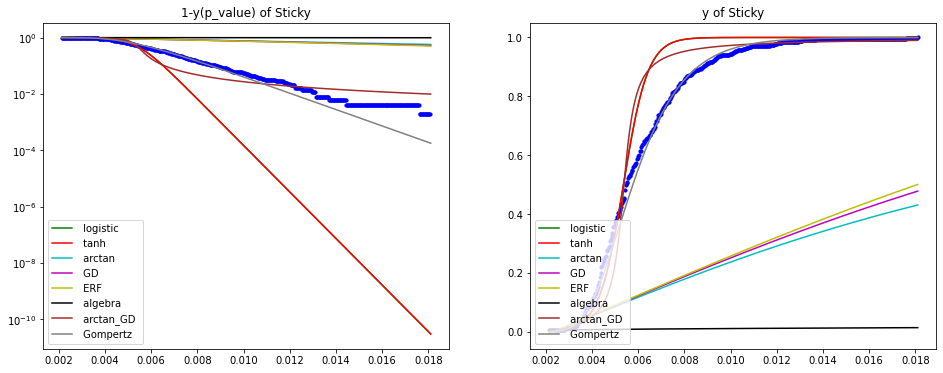

In [36]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_comb,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors)

#### CE

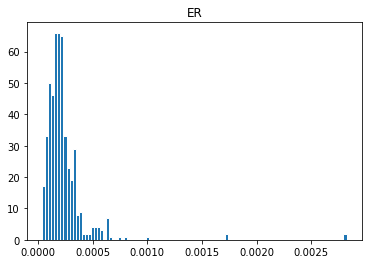

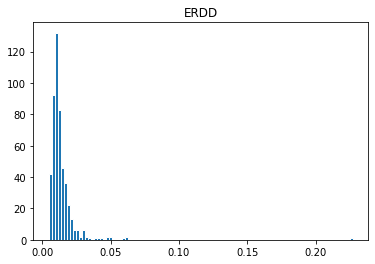

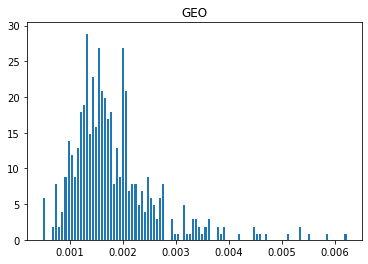

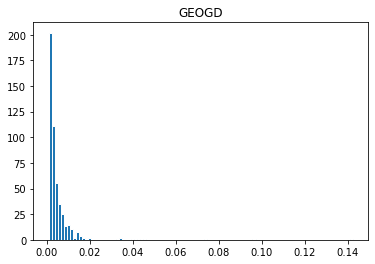

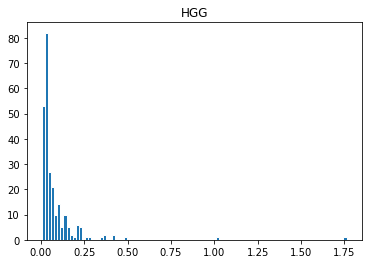

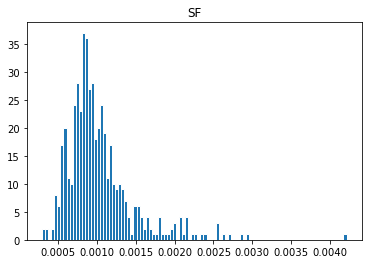

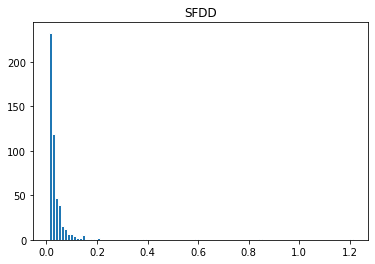

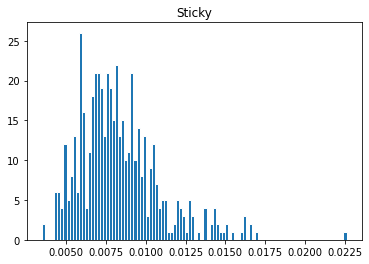

In [26]:
c = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky']
for i in c:
    data_i = data_distance(data(df_CE,i))
    plot_data_distance(data_i,i)

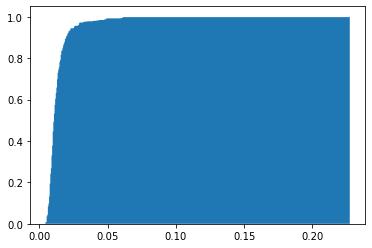

(array([0.00446796, 0.00491375, 0.00535953, 0.00580532, 0.00625111,
        0.00669689, 0.00714268, 0.00758847, 0.00803426, 0.00848004,
        0.00892583, 0.00937162, 0.0098174 , 0.01026319, 0.01070898,
        0.01115476, 0.01160055, 0.01204634, 0.01249212, 0.01293791,
        0.0133837 , 0.01382949, 0.01427527, 0.01472106, 0.01516685,
        0.01561263, 0.01605842, 0.01650421, 0.01694999, 0.01739578,
        0.01784157, 0.01828736, 0.01873314, 0.01917893, 0.01962472,
        0.0200705 , 0.02051629, 0.02096208, 0.02140786, 0.02185365,
        0.02229944, 0.02274523, 0.02319101, 0.0236368 , 0.02408259,
        0.02452837, 0.02497416, 0.02541995, 0.02586573, 0.02631152,
        0.02675731, 0.02720309, 0.02764888, 0.02809467, 0.02854046,
        0.02898624, 0.02943203, 0.02987782, 0.0303236 , 0.03076939,
        0.03121518, 0.03166096, 0.03210675, 0.03255254, 0.03299833,
        0.03344411, 0.0338899 , 0.03433569, 0.03478147, 0.03522726,
        0.03567305, 0.03611883, 0.03656462, 0.03

In [20]:
erdd = data_distance(data(df_CE,'ERDD'))
empirical_CDF(erdd,True,"ERDD")

In [18]:
np.sort(erdd)

array([0.00446796, 0.00446796, 0.00465987, 0.00465987, 0.0053608 ,
       0.0053608 , 0.00540052, 0.00540052, 0.00542853, 0.00542853,
       0.00557916, 0.00557916, 0.00559739, 0.00559739, 0.0057245 ,
       0.0057245 , 0.00579291, 0.00579291, 0.00583841, 0.00583841,
       0.00610969, 0.00610969, 0.00625552, 0.00625552, 0.0062566 ,
       0.0062566 , 0.00645246, 0.00645246, 0.00646638, 0.00646638,
       0.00651589, 0.00651589, 0.00653543, 0.00653543, 0.00654309,
       0.00654309, 0.0065677 , 0.0065677 , 0.00663338, 0.00663338,
       0.00667302, 0.00667302, 0.00690438, 0.00690438, 0.00706179,
       0.00706179, 0.00710276, 0.00713604, 0.00713604, 0.00716562,
       0.00719857, 0.00728046, 0.00728046, 0.00728869, 0.00728869,
       0.00729327, 0.00729327, 0.00730514, 0.00730514, 0.00736613,
       0.00736613, 0.00740942, 0.00748016, 0.00753721, 0.00753721,
       0.00755001, 0.00759992, 0.00759992, 0.00760211, 0.00760211,
       0.00761367, 0.00761367, 0.00763186, 0.00763186, 0.00767

In [33]:
# 4.11
## 1 without binning

##2 same # of items in each bin
## => sqrt(n) bins -> sqrt(n) pts/bin 
# x=0, y=0
## y(x_1) = 1/n+1
## y(x_i) = i/n+1

In [21]:
factors_CE = [1e-4, 1e-2, 1e-3, 1e-2,1e-1, 1e-4, 1e-1, 1e-4]

For  ER  :
curve_fit parameter on  logistic :  [1.73029012 3.38918075]
curve_fit parameter on  tanh :  [1.73028391 1.69459818]
curve_fit parameter on  arctan :  [0.37132083 0.44922555]
curve_fit parameter on  GD :  [0.36841091 0.20617268]
curve_fit parameter on  ERF :  [0.36751552 0.22688236]
curve_fit parameter on  algebra :  [1.8709861  0.24981659]
curve_fit parameter on  arctan_GD :  [ 0.31882806  1.38350423 -0.92764082]
curve_fit parameter on  Gompertz :  [2.11160151 1.38512701]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


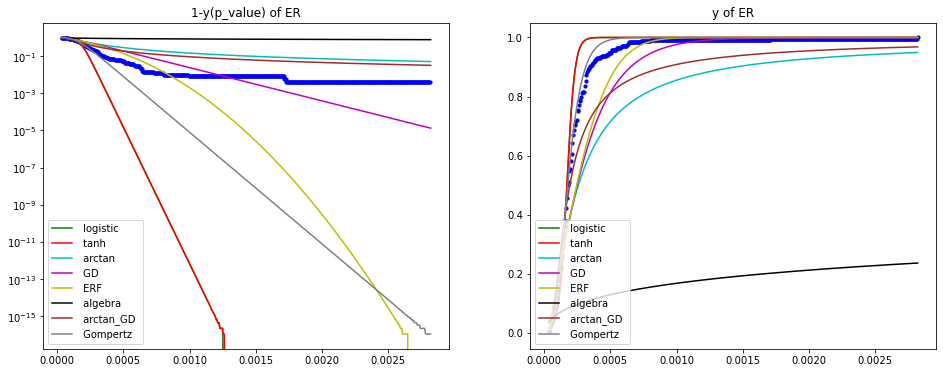

For  ERDD  :
curve_fit parameter on  logistic :  [1.00412187 8.39484189]
curve_fit parameter on  tanh :  [1.00412544 4.19739143]
curve_fit parameter on  arctan :  [0.45739481 0.97889976]
curve_fit parameter on  GD :  [0.45566823 0.44528103]
curve_fit parameter on  ERF :  [0.45520221 0.49040874]
curve_fit parameter on  algebra :  [1.08467194 0.27354095]
curve_fit parameter on  arctan_GD :  [0.45551587 0.41609958 1.12334063]
curve_fit parameter on  Gompertz :  [3.16261803 3.40788745]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


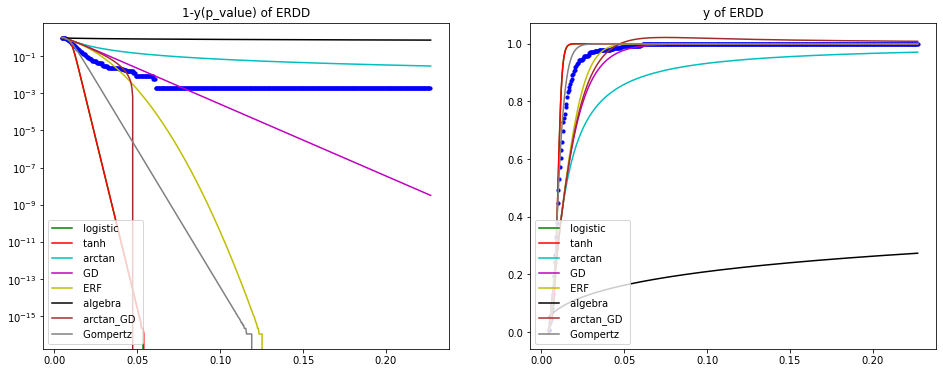

For  GEO  :
curve_fit parameter on  logistic :  [1.57333799 4.46734093]
curve_fit parameter on  tanh :  [1.57333917 2.23366802]
curve_fit parameter on  arctan :  [0.49747383 0.33734711]
curve_fit parameter on  GD :  [0.49831651 0.17160968]
curve_fit parameter on  ERF :  [0.49834157 0.19374113]
curve_fit parameter on  algebra :  [1.6242431  0.17848783]
curve_fit parameter on  arctan_GD :  [ 0.48585263  1.58402017 -0.96851826]
curve_fit parameter on  Gompertz :  [2.55634679 1.72770579]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


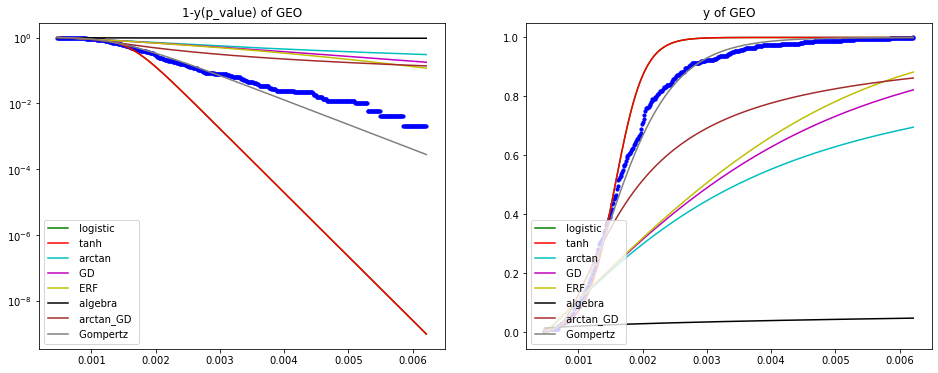

For  GEOGD  :
curve_fit parameter on  logistic :  [ 0.24539349 17.1840957 ]
curve_fit parameter on  tanh :  [0.24539358 8.59204276]
curve_fit parameter on  arctan :  [0.06356002 6.01475473]
curve_fit parameter on  GD :  [0.05980736 2.27005774]
curve_fit parameter on  ERF :  [0.05855419 2.37158207]
curve_fit parameter on  algebra :  [0.24724461 9.53942797]
curve_fit parameter on  arctan_GD :  [0.06189477 3.25415549 0.60757585]
curve_fit parameter on  Gompertz :  [1.77629293 8.74636381]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


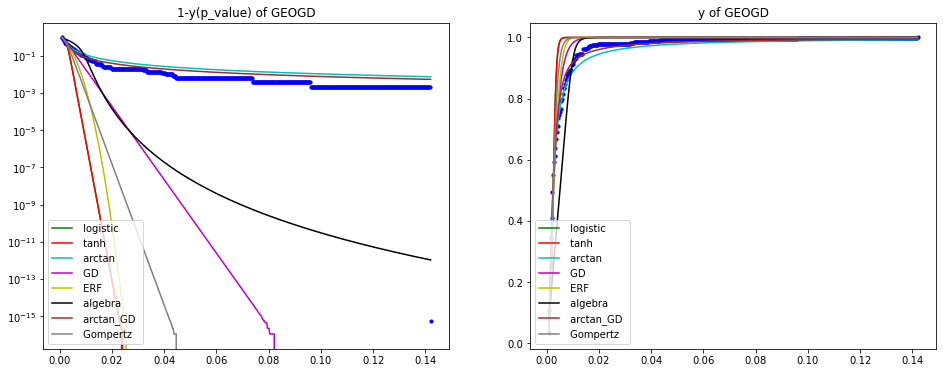

For  HGG  :
curve_fit parameter on  logistic :  [ 0.36520047 12.06389839]
curve_fit parameter on  tanh :  [0.36519863 6.03199128]
curve_fit parameter on  arctan :  [0.0715502  3.28916398]
curve_fit parameter on  GD :  [0.06768323 1.28549535]
curve_fit parameter on  ERF :  [0.06646829 1.35831269]
curve_fit parameter on  algebra :  [0.40294287 3.20954764]
curve_fit parameter on  arctan_GD :  [0.06957519 1.73680146 0.6526218 ]
curve_fit parameter on  Gompertz :  [1.72883006 5.60050115]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


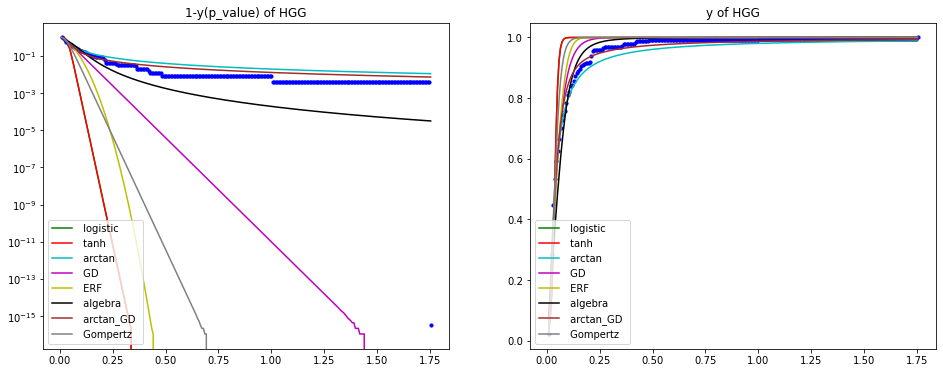

For  SF  :
curve_fit parameter on  logistic :  [8.8737892  0.95707634]
curve_fit parameter on  tanh :  [8.87380537 0.47853658]
curve_fit parameter on  arctan :  [3.26047405 0.04255701]
curve_fit parameter on  GD :  [3.26735512 0.02194642]
curve_fit parameter on  ERF :  [3.26905175 0.02496129]
curve_fit parameter on  algebra :  [9.20819632 0.12761562]
error in   arctan_GD 
curve_fit parameter on  Gompertz :  [-31.46974449 -12.0290846 ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


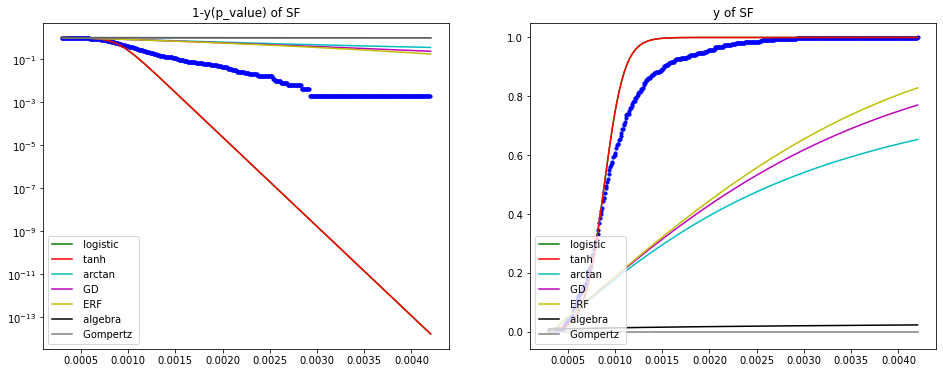

For  SFDD  :
curve_fit parameter on  logistic :  [ 0.21360223 16.13795398]
curve_fit parameter on  tanh :  [0.213601   8.06906921]
curve_fit parameter on  arctan :  [0.0682244  8.50791819]
curve_fit parameter on  GD :  [0.05985405 2.9975771 ]
curve_fit parameter on  ERF :  [0.05692126 3.07540499]
curve_fit parameter on  algebra :  [ 0.21892582 20.90831978]
curve_fit parameter on  arctan_GD :  [0.06328224 3.92639388 0.7228186 ]
curve_fit parameter on  Gompertz :  [1.63462843 9.56250061]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


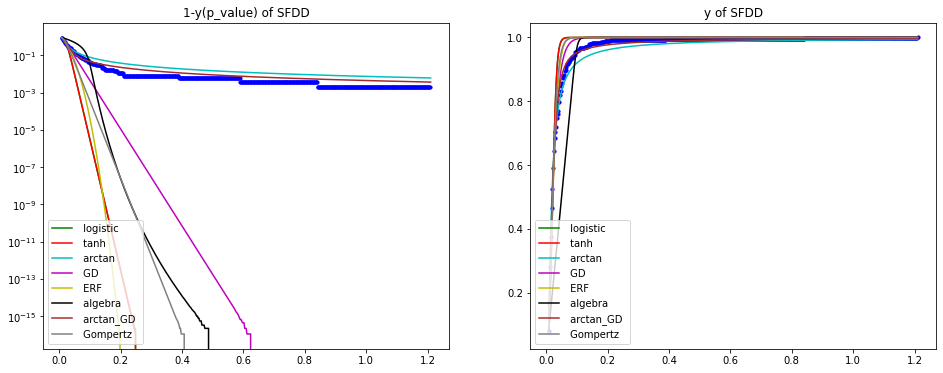

For  Sticky  :
curve_fit parameter on  logistic :  [75.12290527  0.14659262]
curve_fit parameter on  tanh :  [7.51227378e+01 7.32966594e-02]
curve_fit parameter on  arctan :  [3.75752540e+01 5.57713633e-03]
curve_fit parameter on  GD :  [3.76293790e+01 2.90459006e-03]
curve_fit parameter on  ERF :  [3.76511554e+01 3.33327595e-03]
curve_fit parameter on  algebra :  [78.50832208  0.10087706]
error in   arctan_GD 
curve_fit parameter on  Gompertz :  [1. 1.]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


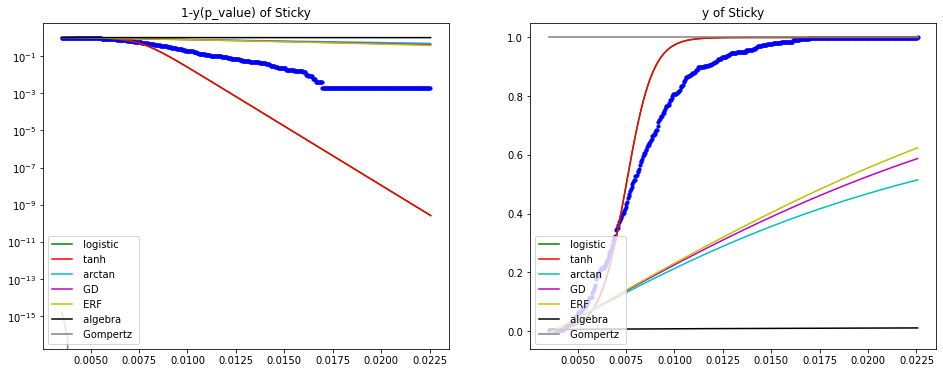

In [24]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_CE[i], functions, colors)